#Lib's Installation

In [ ]:
!pip install nbconvert
!pip install matplotlib
!pip install seaborn
!pip install prettytable
!pip install tensorflow
!pip install transformers
!pip install torch

In [ ]:
!pip install unzip

In [ ]:
!unzip dataset.zip

In [ ]:
data_folder = "dataset"

#Importing necessadry Lib's:

For data manipulation (pandas), model building and evaluation (sklearn, transformers, tensorflow), image processing (cv2, PIL), and visualization (matplotlib, seaborn, prettytable)

In [ ]:
import pandas as pd
import numpy as np
import requests
import cv2
from io import BytesIO
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer, AutoModel
from tensorflow import keras
from tensorflow.keras import layers
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
import prettytable
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
dataset_limit = 100  # dataset limit

#Loading and Prepare Data

In [ ]:
train_file = 'dataset/train.tsv'
test_file = 'dataset/test.tsv'
validate_file = 'dataset/validate.tsv'

train_df = pd.read_csv(train_file, sep='\t').head(dataset_limit)
test_df = pd.read_csv(test_file, sep='\t').head(dataset_limit)
validate_df = pd.read_csv(validate_file, sep='\t').head(dataset_limit)
print(f"Loading datasets with a limit of {dataset_limit} rows...")

print(train_df.head(0))
print(test_df.head(0))
print(validate_df.head(0))

Loading datasets with a limit of 100 rows...
Empty DataFrame
Columns: [author, clean_title, created_utc, domain, hasImage, id, image_url, linked_submission_id, num_comments, score, subreddit, title, upvote_ratio, 2_way_label, 3_way_label, 6_way_label]
Index: []
Empty DataFrame
Columns: [author, clean_title, created_utc, domain, hasImage, id, image_url, linked_submission_id, num_comments, score, subreddit, title, upvote_ratio, 2_way_label, 3_way_label, 6_way_label]
Index: []
Empty DataFrame
Columns: [author, clean_title, created_utc, domain, hasImage, id, image_url, linked_submission_id, num_comments, score, subreddit, title, upvote_ratio, 2_way_label, 3_way_label, 6_way_label]
Index: []


In [ ]:
# Picking relavant columns
selected_columns = ['author', 'clean_title', 'domain', 'image_url', '2_way_label']

train_df = train_df[selected_columns]
test_df = test_df[selected_columns]
validate_df = validate_df[selected_columns]

print(train_df.head(0))
print(test_df.head(0))
print(validate_df.head(0))


Empty DataFrame
Columns: [author, clean_title, domain, image_url, 2_way_label]
Index: []
Empty DataFrame
Columns: [author, clean_title, domain, image_url, 2_way_label]
Index: []
Empty DataFrame
Columns: [author, clean_title, domain, image_url, 2_way_label]
Index: []


In [ ]:
# Extracting labels and split the data
train_labels = train_df['2_way_label'].values
test_labels = test_df['2_way_label'].values
validate_labels = validate_df['2_way_label'].values

#Tokenizing Text

#Ernie

In [ ]:
# Function to encode text using ERNIE
def encode_text_ernie(author, clean_title, domain):
    print("Encoding text using ERNIE...")
    tokenizer = AutoTokenizer.from_pretrained('nghuyong/ernie-2.0-en')
    model = AutoModel.from_pretrained('nghuyong/ernie-2.0-en')

    text = f"{author} {clean_title} {domain}"
    input_ids = tokenizer.encode(text, return_tensors='pt', max_length=512, truncation=True)

    with torch.no_grad():
        outputs = model(input_ids)

    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    print("Text encoded using ERNIE.")
    return embeddings


#Vectorizing Images

In [ ]:
# Function to vectorize image from URL
def vectorize_image_from_url(url, target_size=(224, 224)):
    try:
        print(f"Loading image from URL: {url}")
        response = requests.get(url)
        response.raise_for_status()  # Check for successful response
        image = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)

        if image is None:
            raise Exception("Failed to decode image from URL.")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)  # Resize to a consistent size
        image_array = image.astype(np.float32) / 255.0

        print(f"Image loaded successfully from URL: {url}")
        return image_array

    except Exception as e:
        print(f"Error processing image from URL {url}: {str(e)}")
        return None

#Encode Text and Vectorize Images

##ERNIE

In [ ]:
# Encode text and vectorize images for training set using ERNIE
train_embeddings_ernie = []
X_train_image_ernie = []

for author, clean_title, domain, img_url, lbl in zip(train_df['author'], train_df['clean_title'], train_df['domain'], train_df['image_url'], train_df['2_way_label']):
    text_embedding = encode_text_ernie(author, clean_title, domain)
    image_embedding = vectorize_image_from_url(img_url)

    if text_embedding is not None and image_embedding is not None:
        train_embeddings_ernie.append(text_embedding)
        X_train_image_ernie.append(image_embedding)

train_embeddings_ernie = np.array(train_embeddings_ernie)
X_train_image_ernie = np.array(X_train_image_ernie)


In [ ]:
# Encode text and vectorize images for testing set using ERNIE
test_embeddings_ernie = []
X_test_image_ernie = []

for author, clean_title, domain, img_url, lbl in zip(test_df['author'], test_df['clean_title'], test_df['domain'], test_df['image_url'], test_df['2_way_label']):
    text_embedding = encode_text_ernie(author, clean_title, domain)
    image_embedding = vectorize_image_from_url(img_url)

    if text_embedding is not None and image_embedding is not None:
        test_embeddings_ernie.append(text_embedding)
        X_test_image_ernie.append(image_embedding)

test_embeddings_ernie = np.array(test_embeddings_ernie)
X_test_image_ernie = np.array(X_test_image_ernie)


In [ ]:
# Encode text and vectorize images for validation set using ERNIE
validate_embeddings_ernie = []
X_validate_image_ernie = []

for author, clean_title, domain, img_url, lbl in zip(validate_df['author'], validate_df['clean_title'], validate_df['domain'], validate_df['image_url'], validate_df['2_way_label']):
    text_embedding = encode_text_ernie(author, clean_title, domain)
    image_embedding = vectorize_image_from_url(img_url)

    if text_embedding is not None and image_embedding is not None:
        validate_embeddings_ernie.append(text_embedding)
        X_validate_image_ernie.append(image_embedding)

validate_embeddings_ernie = np.array(validate_embeddings_ernie)
X_validate_image_ernie = np.array(X_validate_image_ernie)


# Model Building & Compiling

##ERNIE - Train

In [ ]:
# Neural network model for ERNIE
text_input_ernie = layers.Input(shape=(train_embeddings_ernie.shape[1],))
text_layer_ernie = layers.Dense(128, activation='relu')(text_input_ernie)
image_input_ernie = layers.Input(shape=(224, 224, 3))
image_layer_ernie = layers.Conv2D(64, (3, 3), activation='relu')(image_input_ernie)
image_layer_ernie = layers.MaxPooling2D((2, 2))(image_layer_ernie)
image_layer_ernie = layers.Flatten()(image_layer_ernie)
merged_ernie = layers.concatenate([text_layer_ernie, image_layer_ernie])
output_ernie = layers.Dense(1, activation='sigmoid')(merged_ernie)

In [ ]:
# Build and compile the model for ERNIE
model_ernie = keras.Model(inputs=[text_input_ernie, image_input_ernie], outputs=output_ernie)
model_ernie.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training the model using ERNIE...")

Training the model using ERNIE...


In [ ]:
# Train the model for ERNIE
model_ernie.fit([train_embeddings_ernie, X_train_image_ernie], train_labels, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
3/3 [==============================] - 2s 461ms/step - loss: 7.4472 - accuracy: 0.5333 - val_loss: 6.2247 - val_accuracy: 0.6842
Epoch 2/5
3/3 [==============================] - 1s 375ms/step - loss: 5.2731 - accuracy: 0.5733 - val_loss: 7.3854 - val_accuracy: 0.3158
Epoch 3/5
3/3 [==============================] - 1s 374ms/step - loss: 2.8969 - accuracy: 0.5333 - val_loss: 1.8518 - val_accuracy: 0.6842
Epoch 4/5
3/3 [==============================] - 1s 390ms/step - loss: 1.6715 - accuracy: 0.5867 - val_loss: 1.3894 - val_accuracy: 0.5263
Epoch 5/5
3/3 [==============================] - 1s 382ms/step - loss: 0.5621 - accuracy: 0.7600 - val_loss: 2.4510 - val_accuracy: 0.4737


##ERNIE - Test

In [ ]:
# Define the neural network model for ERNIE
text_input_ernie = layers.Input(shape=(test_embeddings_ernie.shape[1],))
text_layer_ernie = layers.Dense(128, activation='relu')(text_input_ernie)
image_input_ernie = layers.Input(shape=(224, 224, 3))
image_layer_ernie = layers.Conv2D(64, (3, 3), activation='relu')(image_input_ernie)
image_layer_ernie = layers.MaxPooling2D((2, 2))(image_layer_ernie)
image_layer_ernie = layers.Flatten()(image_layer_ernie)
merged_ernie = layers.concatenate([text_layer_ernie, image_layer_ernie])
output_ernie = layers.Dense(1, activation='sigmoid')(merged_ernie)

In [ ]:
# Build and compile the model for ERNIE
model_ernie = keras.Model(inputs=[text_input_ernie, image_input_ernie], outputs=output_ernie)
model_ernie.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training the model using ERNIE...")

Training the model using ERNIE...


In [ ]:
# Train the model for ERNIE
model_ernie.fit([test_embeddings_ernie, X_test_image_ernie], test_labels, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
3/3 [==============================] - 2s 472ms/step - loss: 9.4503 - accuracy: 0.5733 - val_loss: 3.2016 - val_accuracy: 0.4211
Epoch 2/5
3/3 [==============================] - 1s 380ms/step - loss: 3.3886 - accuracy: 0.4667 - val_loss: 2.1871 - val_accuracy: 0.5789
Epoch 3/5
3/3 [==============================] - 1s 378ms/step - loss: 1.8840 - accuracy: 0.6133 - val_loss: 1.1610 - val_accuracy: 0.5789
Epoch 4/5
3/3 [==============================] - 1s 379ms/step - loss: 0.7386 - accuracy: 0.6933 - val_loss: 1.2654 - val_accuracy: 0.4211
Epoch 5/5
3/3 [==============================] - 1s 380ms/step - loss: 0.5371 - accuracy: 0.7200 - val_loss: 0.9073 - val_accuracy: 0.6842


# Models Evaluate and Metrics

In [ ]:
print(len(X_test_image_ernie), len(test_embeddings_ernie), len(test_labels) )

94 94 100


In [ ]:
print(X_test_image_ernie.shape, test_embeddings_ernie.shape, test_labels.shape)


(94, 224, 224, 3) (94, 768) (100,)


In [ ]:
for sample_image, sample_embedding, label in zip(X_test_image_ernie, test_embeddings_ernie, test_labels):
    print(sample_image.shape, sample_embedding.shape, label)

#Ernie

In [ ]:
# Predictions for ERNIE model
predictions_ernie = model_ernie.predict([test_embeddings_ernie, X_test_image_ernie])
print("\nPredictions for ERNIE model:")
print(predictions_ernie)

#Visualization

In [ ]:
# Function to evaluate and print metrics for a model
def evaluate_model(model, X, y, model_name):
    # Adjust the number of samples in labels to match X
    y = y[:len(X[0])]

    # Predictions
    predictions = model.predict(X)

    # Convert probabilities to binary predictions
    binary_predictions = (predictions > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y, binary_predictions)

    # Classification Report
    report = classification_report(y, binary_predictions)

    # Accuracy and Loss
    _, accuracy = model.evaluate(X, y)
    loss = model.evaluate(X, y, return_dict=True)['loss']

    # Prettier Table
    table = prettytable.PrettyTable()
    table.field_names = ["Metric", "Value"]
    table.add_row(["Accuracy", f"{accuracy:.4f}"])
    table.add_row(["Loss", f"{loss:.4f}"])

    # Print Confusion Matrix
    print(f"\nConfusion Matrix for {model_name} model:")
    print(cm)

    # Print Classification Report
    print(f"\nClassification Report for {model_name} model:")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {model_name} model")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Bar plot for Binary Predictions
    plt.figure(figsize=(8, 6))
    sns.countplot(x=binary_predictions.flatten())
    plt.title(f"Binary Predictions Distribution for {model_name} model")
    plt.xlabel("Predicted Class")
    plt.ylabel("Count")
    plt.show()

    # Prettier Table
    print(table)


3/3 [==============================] - 0s 91ms/step - loss: 0.5113 - accuracy: 0.7872

Confusion Matrix for ernie model:
[[53  0]
 [20 21]]

Classification Report for ernie model:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        53
           1       1.00      0.51      0.68        41

    accuracy                           0.79        94
   macro avg       0.86      0.76      0.76        94
weighted avg       0.85      0.79      0.77        94



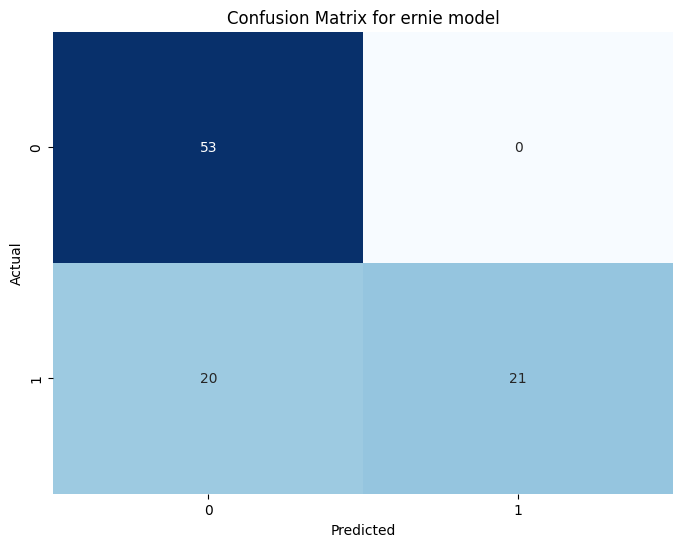

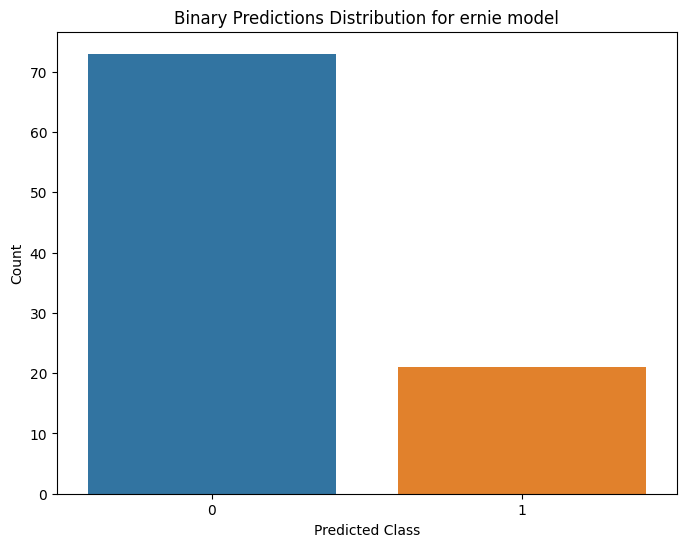

+----------+--------+
|  Metric  | Value  |
+----------+--------+
| Accuracy | 0.7872 |
|   Loss   | 0.5113 |
+----------+--------+


In [ ]:
# Evaluate and print metrics for Ernie model
evaluate_model(model_ernie, [test_embeddings_ernie, X_test_image_ernie], test_labels, "ernie")


In [ ]:
# Train the model for ERNIE
history = model_ernie.fit([train_embeddings_ernie, X_train_image_ernie], train_labels, epochs=5, batch_size=32, validation_split=0.2)

# Extract training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']


Epoch 1/5
3/3 [==============================] - 1s 412ms/step - loss: 1.0938 - accuracy: 0.5467 - val_loss: 0.8843 - val_accuracy: 0.6842
Epoch 2/5
3/3 [==============================] - 1s 375ms/step - loss: 1.0000 - accuracy: 0.5067 - val_loss: 0.9145 - val_accuracy: 0.4211
Epoch 3/5
3/3 [==============================] - 1s 375ms/step - loss: 0.5337 - accuracy: 0.7333 - val_loss: 0.7908 - val_accuracy: 0.6316
Epoch 4/5
3/3 [==============================] - 1s 374ms/step - loss: 0.4809 - accuracy: 0.7467 - val_loss: 0.8880 - val_accuracy: 0.3684
Epoch 5/5
3/3 [==============================] - 1s 379ms/step - loss: 0.3659 - accuracy: 0.8533 - val_loss: 1.2191 - val_accuracy: 0.4211


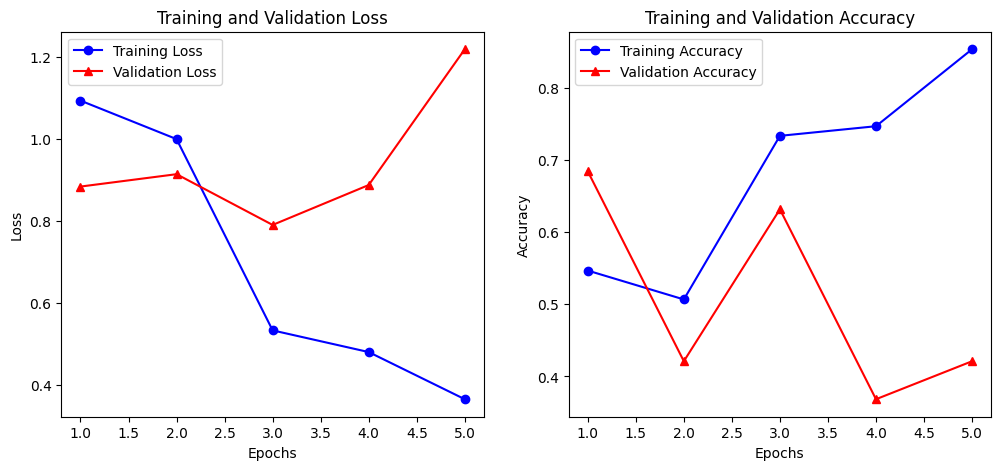

In [ ]:
def plot_learning_curves(training_loss, validation_loss, training_accuracy, validation_accuracy):
    epochs = range(1, len(training_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, validation_loss, 'r^-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'r^-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot learning curves
plot_learning_curves(training_loss, validation_loss, training_accuracy, validation_accuracy)


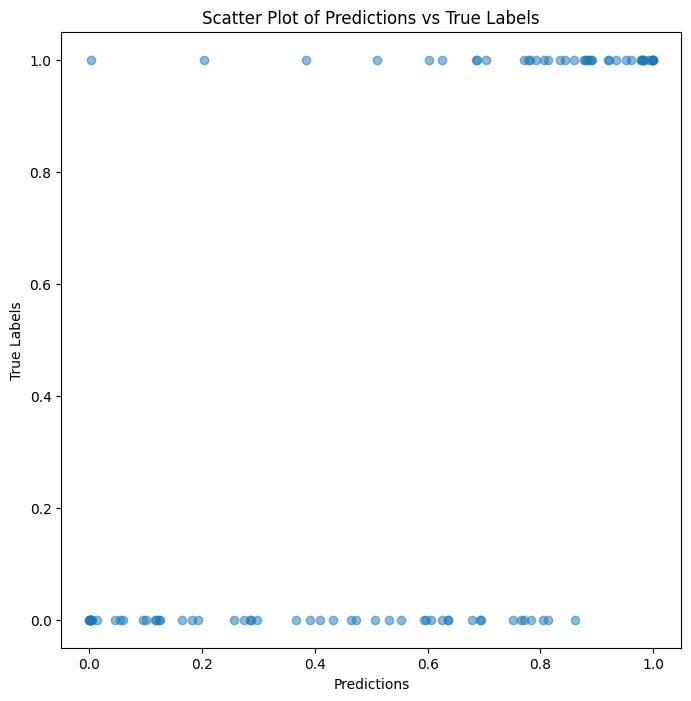

In [ ]:
# Ensure both arrays have the same size
min_size = min(predictions_ernie.shape[0], test_labels.shape[0])
predictions_ernie = predictions_ernie[:min_size]
test_labels = test_labels[:min_size]

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(predictions_ernie, test_labels, alpha=0.5)
plt.title('Scatter Plot of Predictions vs True Labels')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()


In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
!jupyter nbconvert --to PDF "FinalCut.ipynb"

[NbConvertApp] Converting notebook FinalCut.ipynb to PDF
[NbConvertApp] Support files will be in FinalCut_files/
[NbConvertApp] Making directory ./FinalCut_files
[NbConvertApp] Making directory ./FinalCut_files
[NbConvertApp] Writing 102635 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 114161 bytes to FinalCut.pdf
